#Осенний буткемп "AI ARROW"

## Домашнее задание
Все задания рекомендуем выполнять на GPU в Colab.

### Задание 1 - Классификация MNIST c помощью Pytorch (5 баллов)

In [ ]:
# Импортируем необходимые библиотеки

from IPython.display import clear_output, display
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from tqdm.auto import trange

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

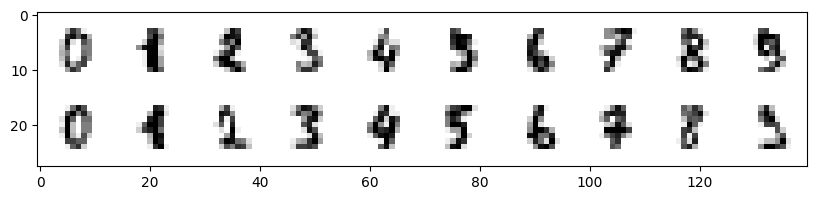

In [ ]:
# Загрузка датасета MNIST
images, targets = load_digits(return_X_y=True)

# Отображение классов и изображений
grid = np.pad(images[:20].reshape(20, 8, 8), [[0, 0], [3, 3], [3, 3]]).reshape(2, 10, 14, 14).swapaxes(1, 2).reshape(28, -1)
plt.figure(figsize=(10, 2))
plt.imshow(grid, cmap='gray_r')
targets[:20].reshape(2, 10)

In [ ]:
# Разделение на train и test
images_train, images_test, targets_train, targets_test = train_test_split(images, targets, test_size=0.3, random_state=42, stratify=targets)

# Создаем torch tensor из np.array
images_train = torch.from_numpy(images_train.astype(np.float32))
images_test = torch.from_numpy(images_test.astype(np.float32))
targets_train = torch.from_numpy(targets_train)
targets_test = torch.from_numpy(targets_test)

#### Отладка без обучения нс.

In [ ]:
hidden_dim_size = 80
input_size = 8 * 8
number_of_classes = 10

# Определяем полносвязную нейронную сеть с двумя Linear слоями и функцией активации ReLU между ними
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)

In [ ]:
# Первый прогон данных через необученную нс.
net_outputs = net(images_train[:2])
net_outputs

tensor([[-0.9812, -1.0469, -5.1180, -0.0592,  2.6312,  0.9095,  1.1879,  1.5715,
          3.7910, -2.3219],
        [-0.6950,  0.4577, -3.4588,  1.0439,  1.3850, -0.3989,  2.3013,  2.3705,
          2.0289, -1.2756]], grad_fn=<AddmmBackward0>)

In [ ]:
print(torch.all((0 <= net_outputs) & (net_outputs <= 1)))
print(net_outputs.sum(dim=-1))

tensor(False)
tensor([0.5640, 3.7589], grad_fn=<SumBackward1>)


In [ ]:
# Применение Softmax на выходе нс. для получения вероятностей
softmax = torch.nn.Softmax(dim=-1)
probabilities = softmax(net_outputs)

print(torch.all((0 <= probabilities) & (probabilities <= 1)))
print(probabilities.sum(dim=-1))

tensor(True)
tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)


In [ ]:
# Определение позиции элемента с максимальных значением вероятности
max_probabilies, ids_of_max_probabilities = probabilities.max(dim=-1)
ids_of_max_probabilities

tensor([8, 7])

In [ ]:
# Определение и применение функции потерь CrossEntropyLoss из библиотеки torch
loss_function =  torch.nn.CrossEntropyLoss()
loss_function(net_outputs, targets_train[:2])

tensor(3.2547, grad_fn=<NllLossBackward0>)

#### Обучение нс.

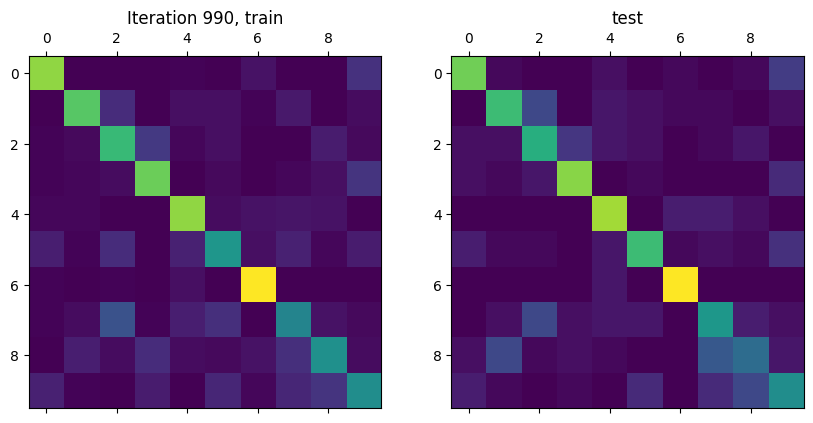

In [ ]:
hidden_dim_size = 80
input_size = 8 * 8
number_of_classes = 10

# Определяем полносвязную нейронную сеть с двумя Linear слоями и функцией активации ReLU между ними
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)

# Применить оптимизатор SGD из torch, установить learning rate равный 1e-3
optimizer = torch.optim.SGD(net.parameters(), lr=0.1e-3)

# Определение функции потерь
loss_function = torch.nn.CrossEntropyLoss()

# Для визуализации обучения
fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=[10, 5])

# Визуализация матрицы ошибок
def visualize():
    ax_train.clear()
    ax_train.set_title(f'Iteration {iter_i}, train')
    ax_train.matshow(confusion_matrix(targets_train, get_predicted_classes(images_train)))
    ax_test.set_title(f'test')
    ax_test.matshow(confusion_matrix(targets_test, get_predicted_classes(images_test)))
    clear_output(wait=True)
    display(fig)

def get_predicted_classes(images):
    return softmax(net(images).detach()).max(dim=-1)[1]

iters_n = 1000

# Цикл обучения
for iter_i in range(iters_n):

    # Передаем данные в нс. получаем ответы
    nn_outputs = net(images_train)

    # Считаем ошибку итерации обучения
    loss = loss_function(nn_outputs, targets_train)

    # Обнуляем градиенты
    optimizer.zero_grad()

    # Считаем градиенты и делаем обратное распространение ошибки
    loss.backward()

    # Делаем шаг оптимизатора
    optimizer.step()

    # Отрисовка матрицы ошибок каждые 10 эпох
    if iter_i % 10 == 0:
        visualize()
plt.close()

### Задание 2 - Классификация котов и собак (15 баллов)

In [ ]:
# Загрузим и распакуем датасет
!wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
!unzip -n data.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train_11k/dog/dog.11174.jpg  
  inflating: data/train_11k/dog/dog.11175.jpg  
  inflating: data/train_11k/dog/dog.11177.jpg  
  inflating: data/train_11k/dog/dog.11180.jpg  
  inflating: data/train_11k/dog/dog.11182.jpg  
  inflating: data/train_11k/dog/dog.11183.jpg  
  inflating: data/train_11k/dog/dog.11185.jpg  
  inflating: data/train_11k/dog/dog.11189.jpg  
  inflating: data/train_11k/dog/dog.1119.jpg  
  inflating: data/train_11k/dog/dog.11190.jpg  
  inflating: data/train_11k/dog/dog.11193.jpg  
  inflating: data/train_11k/dog/dog.11194.jpg  
  inflating: data/train_11k/dog/dog.11196.jpg  
  inflating: data/train_11k/dog/dog.11197.jpg  
  inflating: data/train_11k/dog/dog.11198.jpg  
  inflating: data/train_11k/dog/dog.1120.jpg  
  inflating: data/train_11k/dog/dog.11201.jpg  
  inflating: data/train_11k/dog/dog.11202.jpg  
  inflating: data/train_11k/dog/dog.11204.jpg  
  inflating: data/trai

In [ ]:
# Импортируем необходимые библиотеки

import os
from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

In [ ]:
# Зафиксируем random seed для воспроизводимости результатов
torch.manual_seed(22)

In [ ]:
# Определим в одном месте все константы, которые понадобятся нам в дальнейшем.
# Их смысл будет прояснён по мере использования

# Путь до датасета
DATA_PATH = 'data'

# Количество потоков для data loader
NUM_WORKERS = 4

# Размер изображения и кол-во каналов
SIZE_H = SIZE_W = 96
N_CHANNELS = 3

# Число классов в датасете
NUM_CLASSES = 2

# Количество эпох
EPOCH_NUM = 30

# Размер батча, обычно является 2**N
BATCH_SIZE = 128

# Среднее и среднеквадратичное для нормализации изображения
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Размер последнего слоя (embeddings) CNN модели
EMBEDDING_SIZE = 256

In [ ]:
# Просмотр парамертов GPU.
# Для запуска Colab на GPU: Среда выполнения -> Сменить среду выполнения -> T4 GPU
!nvidia-smi

Fri Nov  1 16:17:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Если GPU активировано, то выполнение команды выдаст такое сообщение

```
Mon Oct 14 20:24:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+
```



In [ ]:
# Используем GPU при наличии
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # Масштабирование изображений до фиксированного размера
    transforms.ToTensor(),                      # Преобразование в тензор
    transforms.Normalize(image_mean, image_std) # Нормализация изображения для каждого канала
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

In [ ]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### Задание 2.1. Изучить содержимое train_loader (1 балл)
Провести исследование данных, на которых обучаемся. Отобразить картинки из батча и вывести их метки

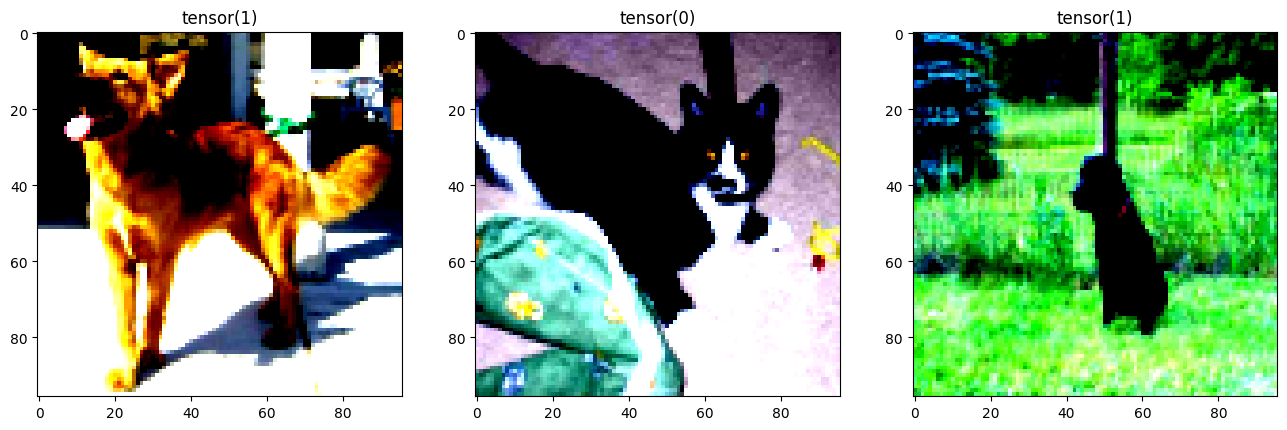

In [ ]:
train_iterator = iter(train_loader)
images_batch, images_labels = next(train_iterator)

#print(images_labels)
#plt.show(images_batch[0].data.cpu())

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title(images_labels[0])
plt.imshow(images_batch[0].permute(1, 2, 0))
plt.subplot(132)
plt.title(images_labels[1])
plt.imshow(images_batch[1].permute(1, 2, 0))
plt.subplot(133)
plt.title(images_labels[2])
plt.imshow(images_batch[2].permute(1, 2, 0))

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):

    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''

    train_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            train_loss.append(loss.item())

        model.train(False)
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100

        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return model, train_loss, val_accuracy

In [ ]:
def test_model(model, test_loader, subset='test'):
    model.train(False)
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)

    print("Results:")
    print(f"  {subset} accuracy:\t\t{test_accuracy * 100:.2f} %")
    if test_accuracy > 0.9:
        print("Amazing!")
    elif test_accuracy > 0.7:
        print("Good!")
    else:
        print("We need more magic! Follow instructons below")
    return test_accuracy

#### Задание 1.2. Реализовать сверточную нейросеть для задачи классификации (4 балла)

**conv-pool-conv-pool-dense-dense!**

Создайте мини-сверточную нейронную сеть со следующей структурой:
* Входной слой
* 3 классических сверточных блока`convolution->relu->pool`:
  * свертка 3x3 с 128 фильтрами и функцией активации _ReLU_
  * 2x2 пулинг (или поставьте для предыдущей свертки страйд = 3)
 * Flatten
* 30% Dropout
* Линейный слой с 256 нейронами и функцией активации _ReLU_
* 30% dropout
* Выходной линейный слой.

__Convolutional layers__ в торче создаются как любой другой слой, но у него есть особые параметры:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # светрка`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2 на 2`__

__`...`__


Когда вы закончите создание нейросети (когда функция compute_loss не будет поднимать ошибки), обучите её с оптимайзером __Adam__ с шагом обучения LR = 3e-4 (learning rate)

Если всё верно, вы должны получить минимум __75%__ точности на валидации.

__Подсказка 1__ : количество каналов должно быть в порядке количества class_labels

__Подсказка 2__ : вы можете поставить stride=2 для Conv2d слоя чтобы увеличить скорость обучения, но помните про размерности

__Подсказка 3__ : можно не считать размерности слоев руками, просто вставьте любую размерность и запуститите (например, 1 юнит) и  запустите compute_loss. Вы получите ошибку:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__
Видите __1960__? Это та размерность, которую вам нужно выставить.

In [ ]:
model_cnn = nn.Sequential()

#...ваш...код... CONV->POOL->CONV-POOL->...
model_cnn.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3))
model_cnn.add_module('relu_1', nn.ReLU())
model_cnn.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3))
model_cnn.add_module('relu_2', nn.ReLU())
model_cnn.add_module('pool2', nn.MaxPool2d(2))
model_cnn.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3))
model_cnn.add_module('relu_3', nn.ReLU())
model_cnn.add_module('pool3', nn.MaxPool2d(2))

model_cnn.add_module('gap_5', nn.AvgPool2d(20))
model_cnn.add_module('dropout_5', nn.Dropout(0.3))
model_cnn.add_module('flat', Flatten())
model_cnn.add_module('fc_6', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())
model_cnn.add_module('dropout_6', nn.Dropout(0.3))
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

model_cnn = model_cnn.to(device)

In [ ]:
summary(model_cnn, train_dataset[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 94, 94]           1,792
              ReLU-2           [-1, 64, 94, 94]               0
            Conv2d-3          [-1, 128, 92, 92]          73,856
              ReLU-4          [-1, 128, 92, 92]               0
         MaxPool2d-5          [-1, 128, 46, 46]               0
            Conv2d-6          [-1, 128, 44, 44]         147,584
              ReLU-7          [-1, 128, 44, 44]               0
         MaxPool2d-8          [-1, 128, 22, 22]               0
         AvgPool2d-9            [-1, 128, 1, 1]               0
          Dropout-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 256]          33,024
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

In [ ]:
# Оптимайзер
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)

# Функция потерь (Лосс функция)
loss_fn = torch.nn.CrossEntropyLoss()

# Число эпох
n_epochs = 30

In [ ]:
opt.zero_grad()
model_cnn, train_loss, val_accuracy = train_model(model_cnn, train_loader, val_loader, loss_fn, opt, n_epochs)

Epoch 1 of 30 took 39.072s
  training loss (in-iteration): 	0.677352
  validation accuracy: 			55.76 %
Epoch 2 of 30 took 39.802s
  training loss (in-iteration): 	0.648639
  validation accuracy: 			61.74 %
Epoch 3 of 30 took 40.550s
  training loss (in-iteration): 	0.636746
  validation accuracy: 			61.10 %
Epoch 4 of 30 took 41.065s
  training loss (in-iteration): 	0.624848
  validation accuracy: 			62.97 %
Epoch 5 of 30 took 40.202s
  training loss (in-iteration): 	0.615971
  validation accuracy: 			59.60 %
Epoch 6 of 30 took 38.390s
  training loss (in-iteration): 	0.605793
  validation accuracy: 			63.99 %
Epoch 7 of 30 took 39.077s
  training loss (in-iteration): 	0.596145
  validation accuracy: 			65.03 %
Epoch 8 of 30 took 39.965s
  training loss (in-iteration): 	0.588110
  validation accuracy: 			65.21 %
Epoch 9 of 30 took 41.406s
  training loss (in-iteration): 	0.577123
  validation accuracy: 			65.29 %
Epoch 10 of 30 took 38.857s
  training loss (in-iteration): 	0.575669
  v

In [ ]:
best_model_cnn = model_cnn

val_accuracy = test_model(best_model_cnn, val_loader, subset='val')
test_accuracy = test_model(best_model_cnn, test_loader, subset='test')

Results:
  val accuracy:		71.41 %
Good!
Results:
  test accuracy:		74.97 %
Good!


### Задание 3 - Знакомство с Roboflow и YOLOv11 (5 баллов)

Зарегистрируйтесь на https://public.roboflow.com/. Изучите возможности сервиса. Попробуйте самостоятельно создать, разметить и экспортировать собственный датасет. Загрузите в Colab датасет - https://universe.roboflow.com/tiger-vliot/tiger-z0d6k

**Подсказка**: см. раздел Dataset

Необходимо будет в ячейке запустить подобную команду:
```
!curl -L "https://universe.roboflow.com/ds/lwP1Jek5kM?key=<ваш ключ>" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
```



In [ ]:
!curl -L "https://universe.roboflow.com/ds/n0FWXcCddm?key=VQ8a9yqIW7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/labels/5Q83Q5EW89N7_jpg.rf.ca4abd060281761f04e2ae066de1e526.txt  
  inflating: train/labels/5Q83Q5EW89N7_jpg.rf.d4e57b06615011349d7e8210b63bbed7.txt  
  inflating: train/labels/5QANEAVFUSPJ_jpg.rf.5afb34af8fa30fee012d4811fb4f0918.txt  
  inflating: train/labels/5QVQ8OEB7YX5_jpg.rf.3b67de86906b9d2f9bdab8a48ff3b3d1.txt  
 extracting: train/labels/5QVQ8OEB7YX5_jpg.rf.6af79b9a4bc0f395dcae91786c29d5f9.txt  
 extracting: train/labels/5QVQ8OEB7YX5_jpg.rf.7d45050c952f0c45b3d3305930d28015.txt  
  inflating: train/labels/5QVQ8OEB7YX5_jpg.rf.aba7911034b3636eab0634cefdf7198d.txt  
  inflating: train/labels/5RBT06O5ILQ0_jpg.rf.a8f9ac03bdea8b44ffb1b530f6d12688.txt  
  inflating: train/labels/5RBT06O5ILQ0_jpg.rf.dd6553af3a3f0e39899e60cda06a4ef0.txt  
  inflating: train/labels/5RZGTS4LJU96_jpg.rf.b87f3b98b49f3eb1d4b1655e016f644d.txt  
  inflating: train/labels/5RZGTS4LJU96_jpg.rf.c8dcfc0c8ba80d9c6214fdfc454daee2.txt

In [ ]:
# Установка библиотеки
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 12.8 MB/s eta 0:00:00


In [ ]:
# Импорт библиотеки
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Исследовать зависимость скорости и качества работы модели от архитектуры (см. на странице - https://docs.ultralytics.com/models/yolo11/#supported-tasks-and-modes), разрешения кадра, кол-ва эпох, размера батча. Выбрать и обосновать не менее 3 конфигураций, обучить модель и провести детекцию на отложенной выборке.

In [ ]:
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 104MB/s]


In [ ]:
results = model.train(data='data.yaml', epochs=10, imgsz=640)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

AMP: checks passed ✅


train: Scanning /content/train/labels... 7316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7316/7316 [00:03<00:00, 1867.12it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/valid/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 689.91it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.692      0.614      0.639      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.775      0.679      0.754      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.825      0.619      0.732      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.834      0.756      0.834      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.891      0.748      0.868      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.865      0.836      0.907      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.909      0.853      0.917      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.891      0.835       0.91        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.918      0.873      0.943      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/458 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this 

                   all        500        627      0.939       0.88      0.956      0.649



10 epochs completed in 0.531 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because 

                   all        500        627      0.938       0.88      0.956      0.649
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


In [ ]:
validation_results = model.val(data='data.yaml', imgsz=640, batch=16, conf=0.25, iou=0.6, device='0')

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because 

                   all        500        627      0.938      0.893      0.949       0.69
Speed: 0.3ms preprocess, 5.8ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train2


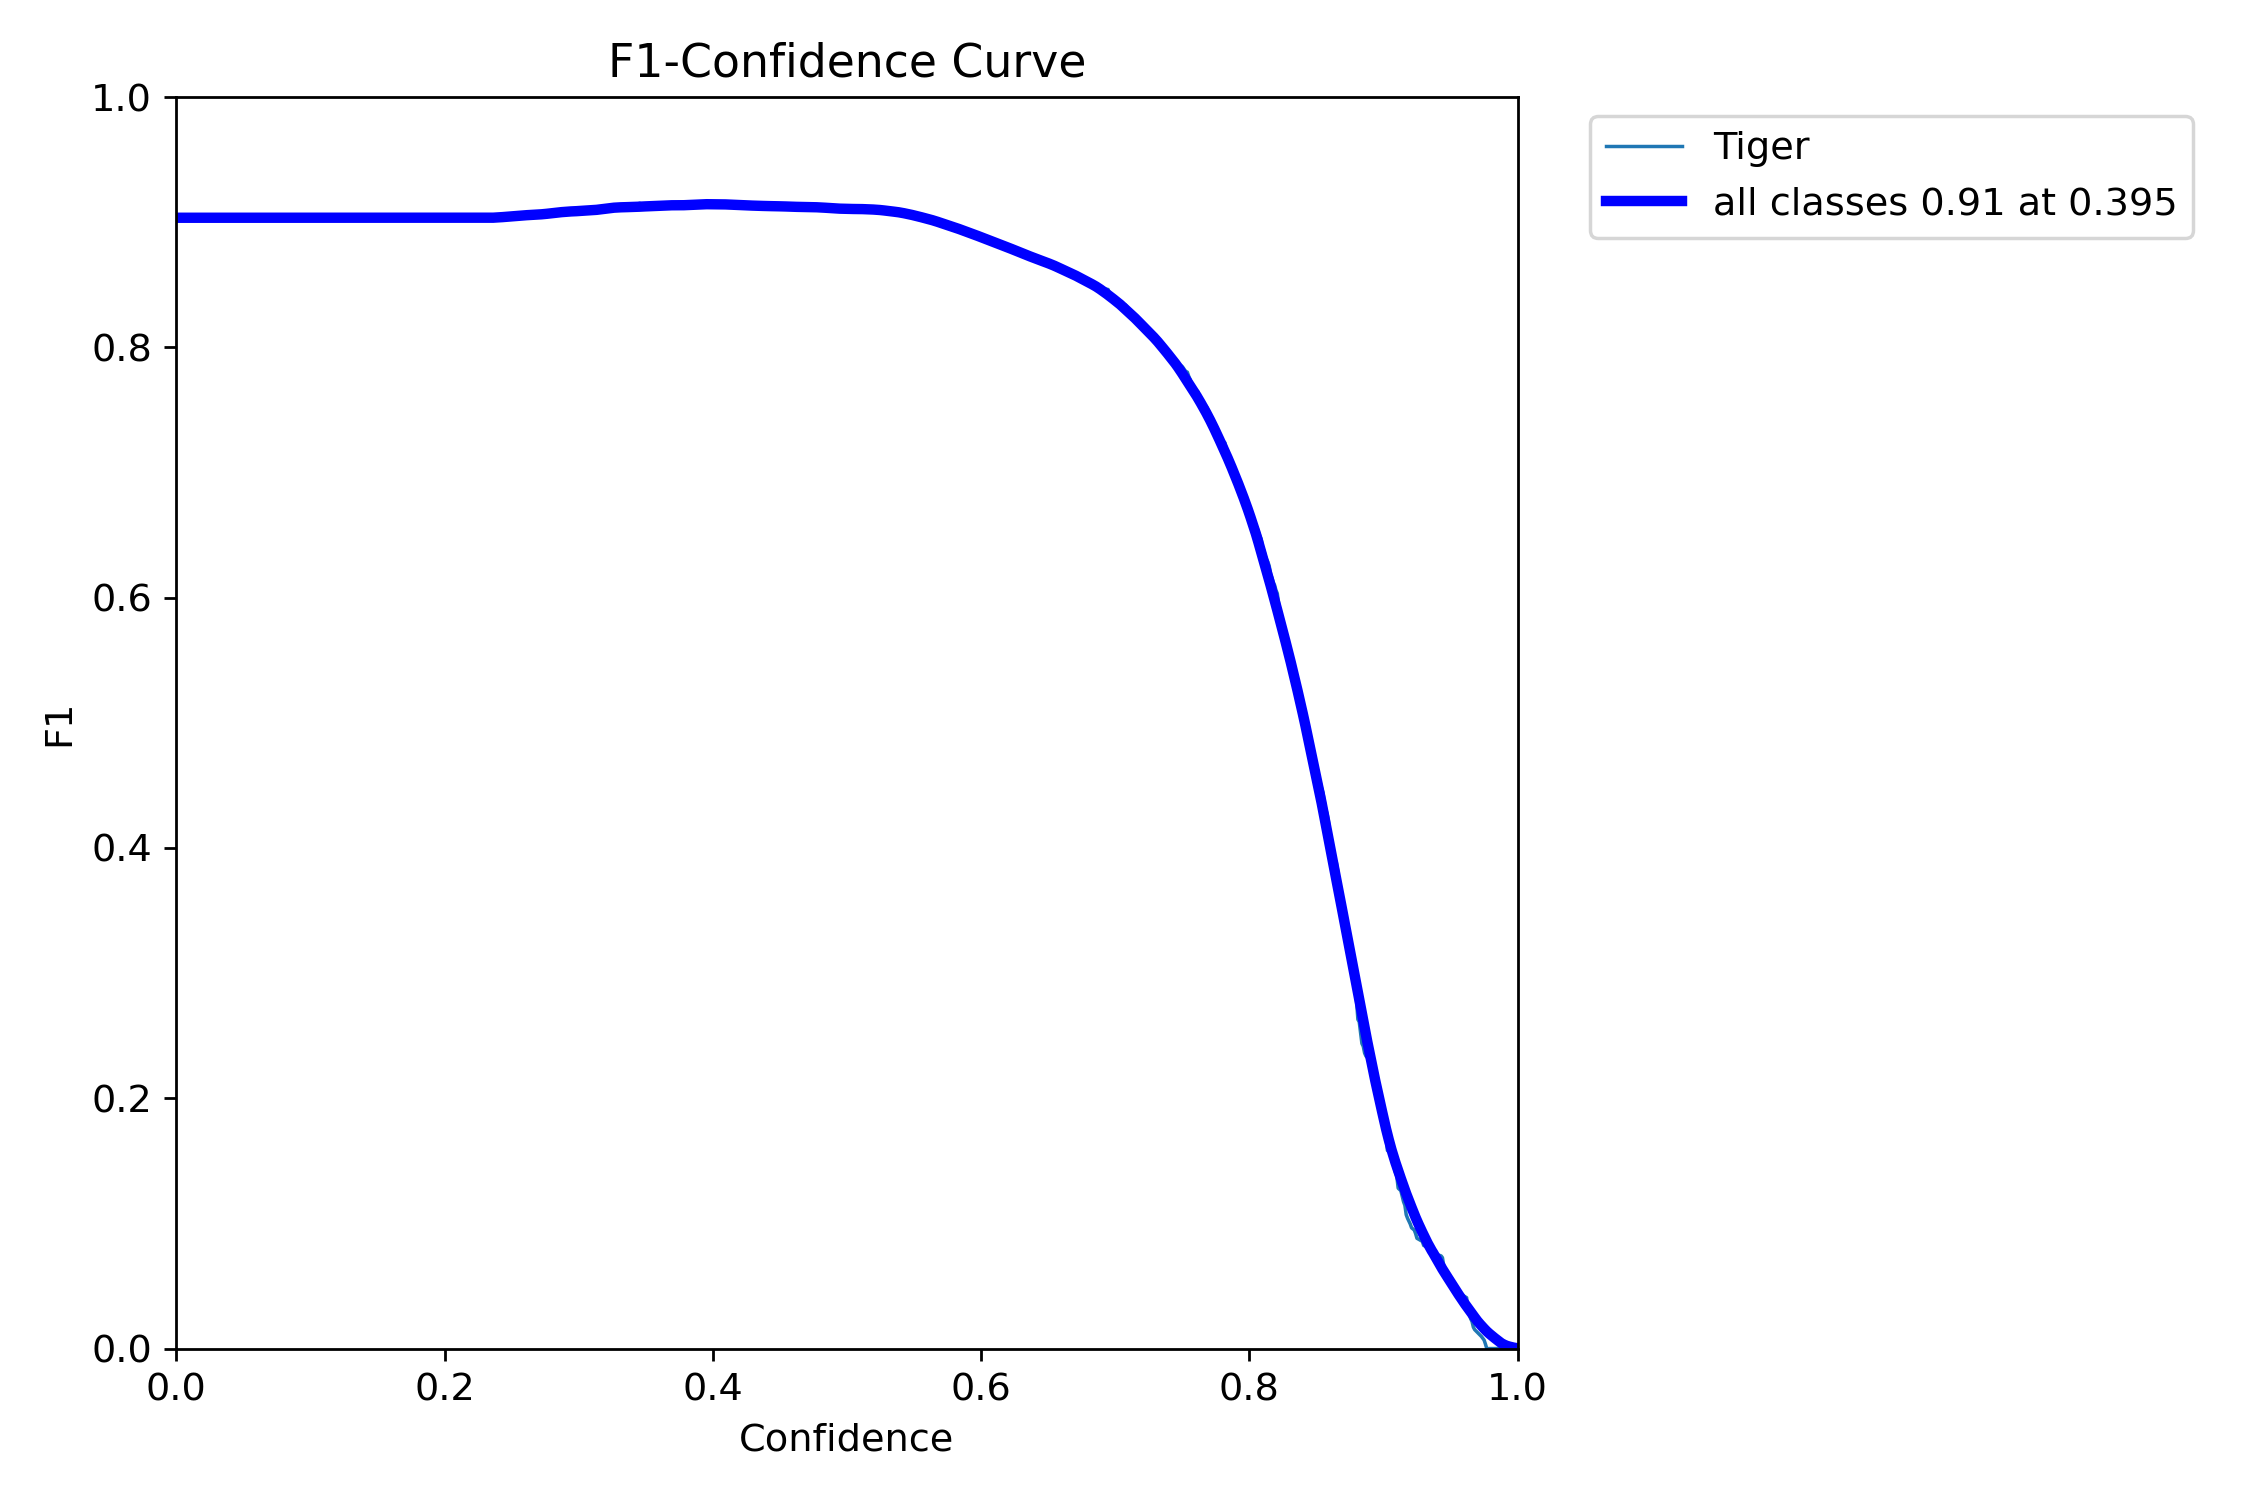

In [ ]:
from IPython.display import Image
Image('/content/runs/detect/train2/F1_curve.png')

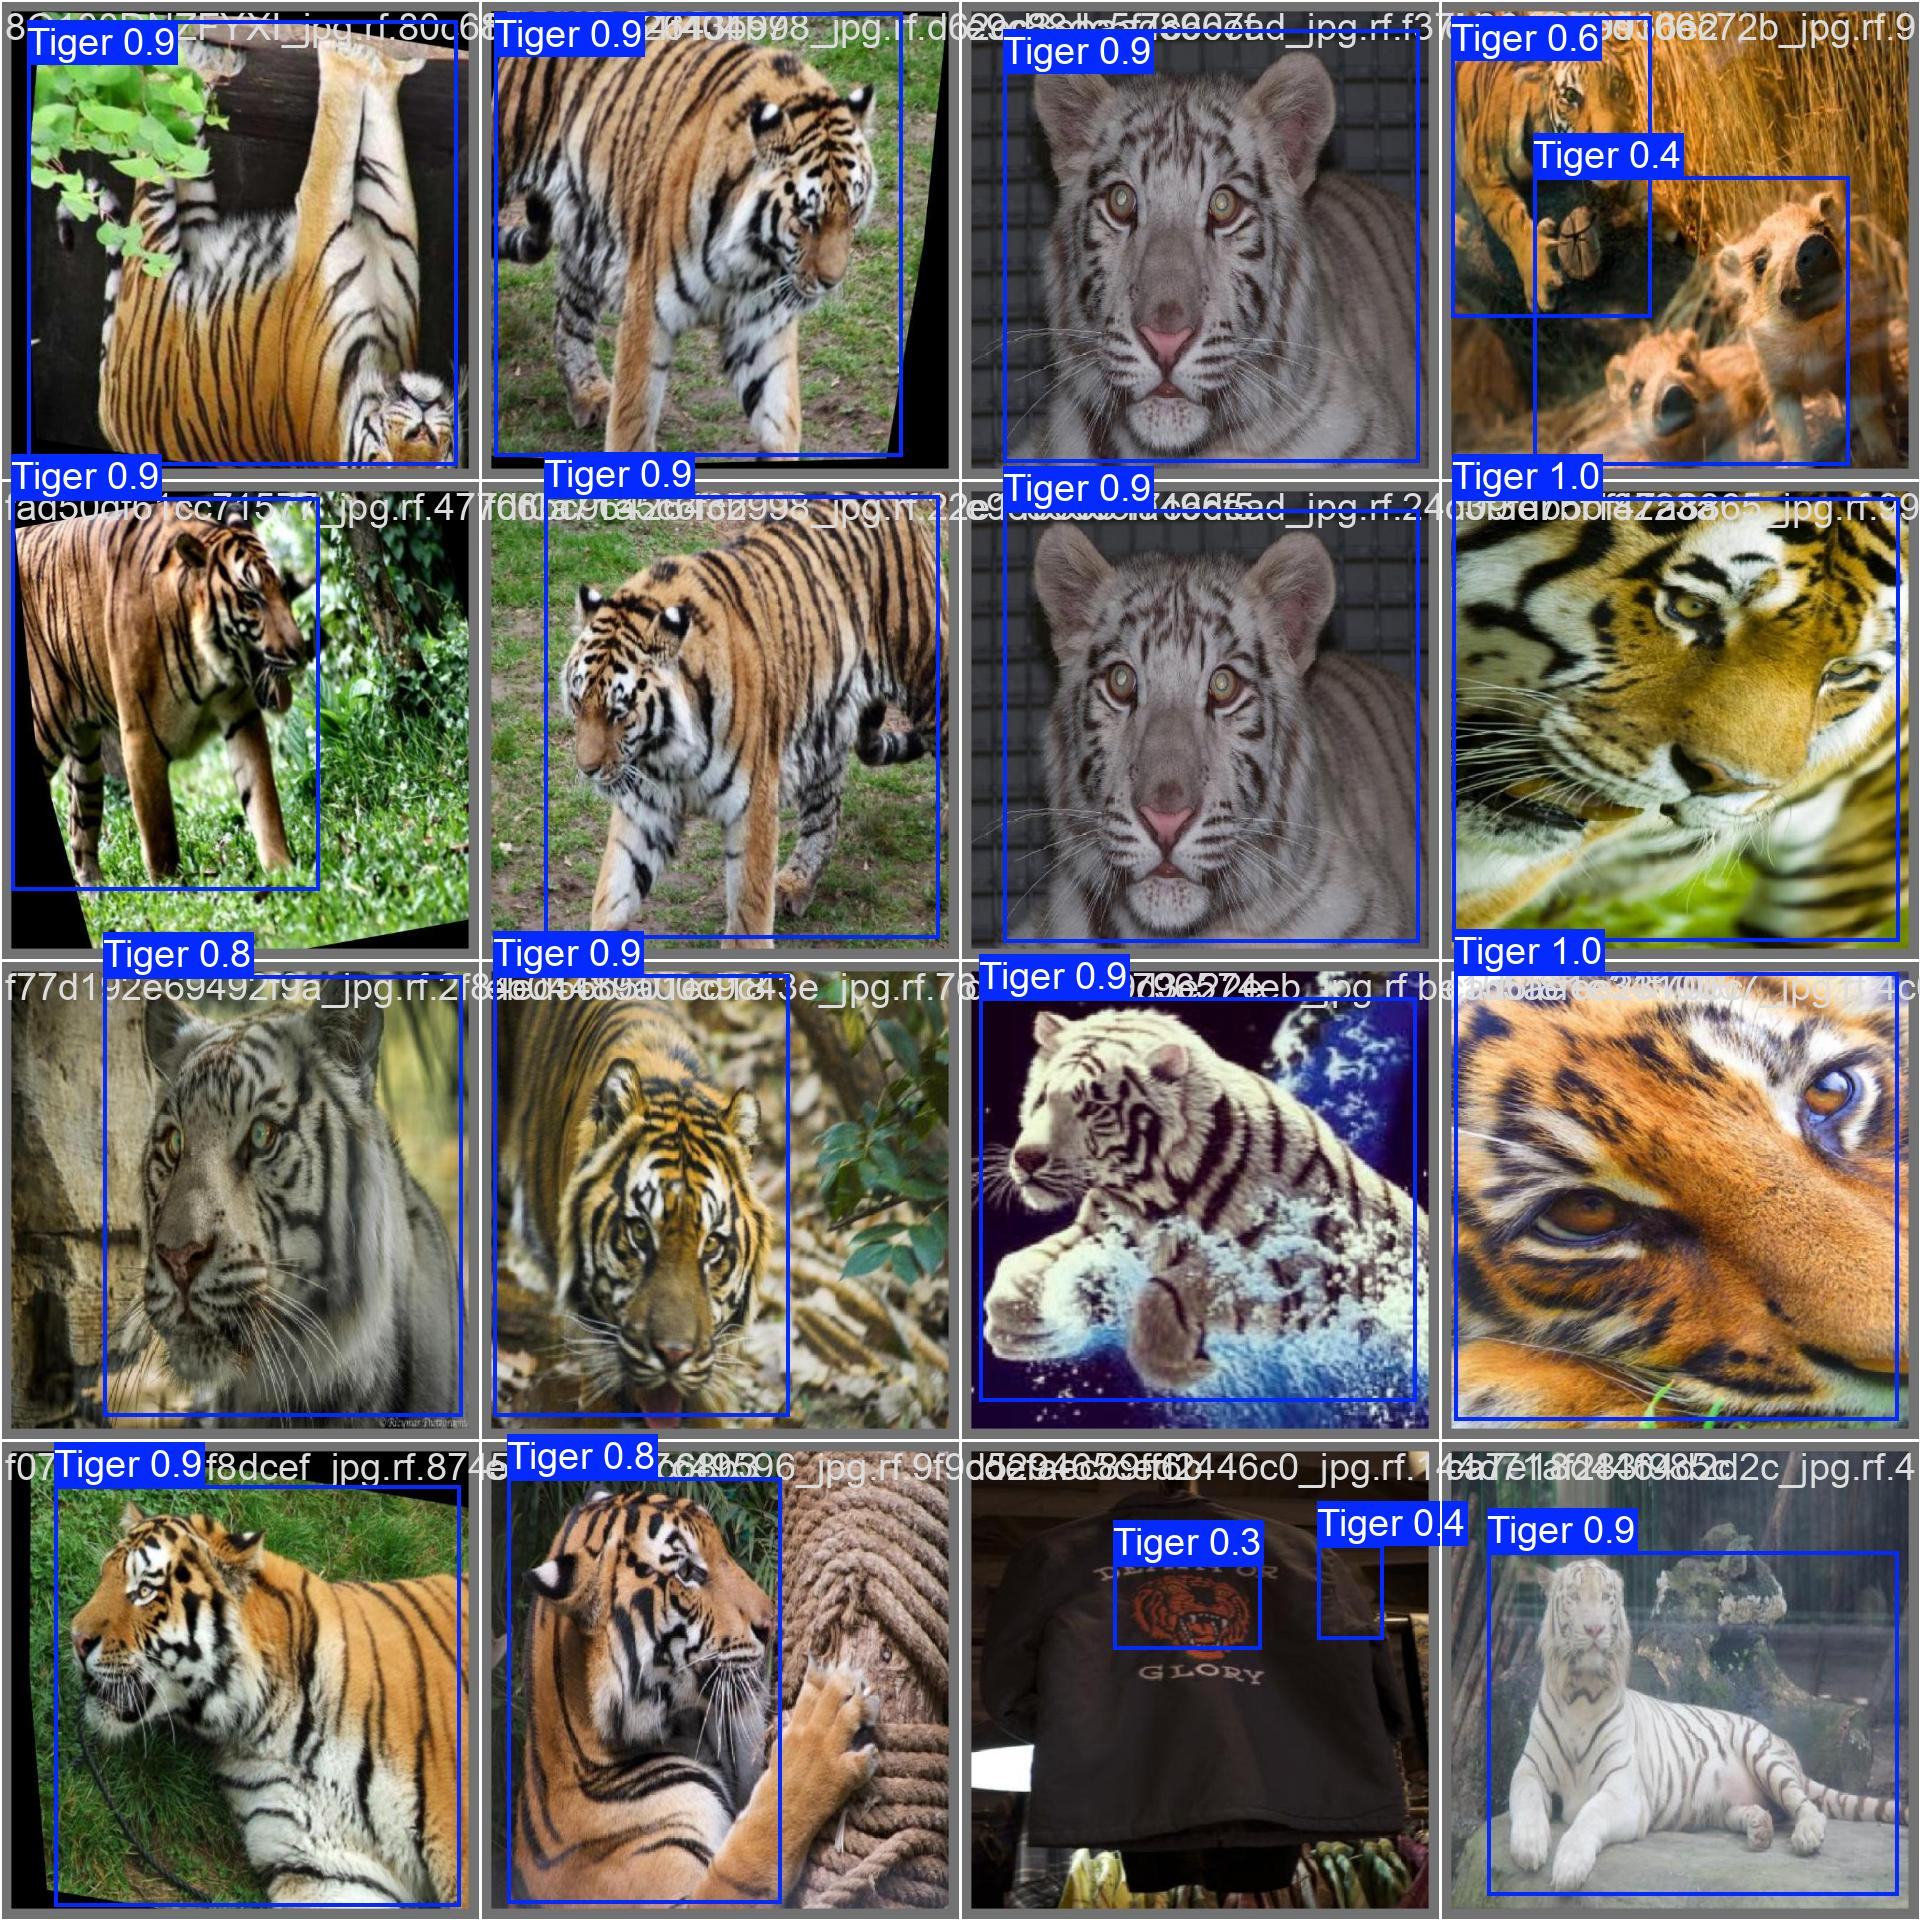

In [ ]:
Image('/content/runs/detect/train2/val_batch0_pred.jpg')